## Word2vec and Classification together
Very large data set of Stack Overflow questions and tags, available at 
https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

## to be removed from exercise but must be present in solution
'''
https://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint_3.ipynb
'''

'\nhttps://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint_3.ipynb\n'

In [3]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(10)


/Users/mousadak/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,narrative,Product
60,I am disputing this debt for XXXX XXXX that is...,Debt collection
91,Ok education credit management corporation XXX...,Debt collection
146,The Account from Ability Recovery Services has...,"Credit reporting, credit repair services, or o..."
171,I made cash & check deposit at my banks atm on...,Checking or savings account
172,Monterey Collection is trying to collect on a ...,Debt collection
173,I was looking through my credit karma and see ...,"Credit reporting, credit repair services, or o..."
174,"Hi, I am constantly being harassed by a compan...",Debt collection
187,I ATTENDED XXXX XXXX XXXX FOR A WHILE THEN COU...,Debt collection
189,First I received communications from Source RM...,Debt collection
208,On Friday XX/XX/18 I was called 6 times in a r...,Debt collection


In [4]:
df = df.sample(frac = 0.01)

In [5]:
df.shape


(3546, 2)

In [6]:
df.index = range(df.shape[0])

In [7]:
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

706849

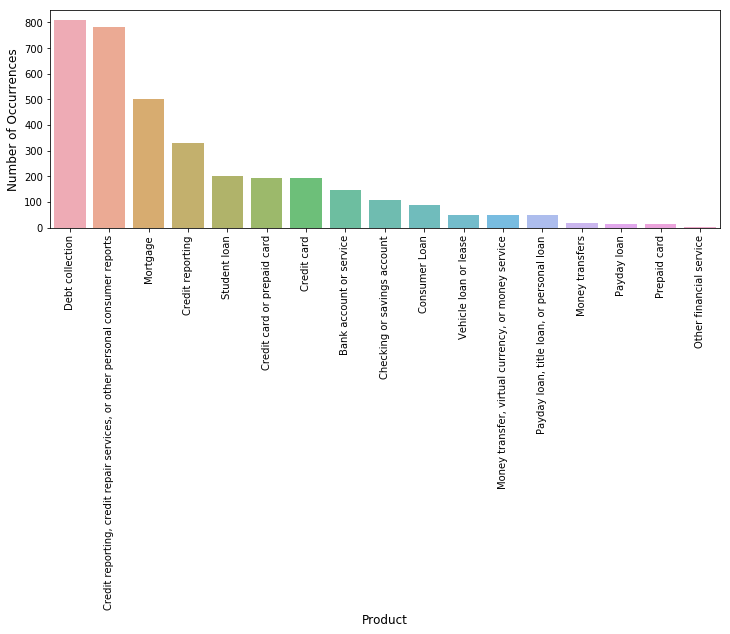

In [8]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The classes are imbalanced. However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

Let's have a look a few examples of complaint narrative and its associated product.


In [9]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])


In [10]:
print_complaint(0)

I opened up a money market account at First Niagara Bank in XXXX XXXX CT on XXXX/XXXX/2016. I was told that the APY interest rate was 1.01 % based on the advertisement in the XXXX XXXX as well as a verbal discussion. There was no mention that the rate was related to compounding and this was confirmed verbally with the bank officer. And that taking out the interest monthly would not affect the rate that I was to receive. After 33 days of " interest '', from XX/XX/XXXX to XX/XX/XXXX, I received not XXXX of 1.01 % but rather XXXX of 0.81 % and my printed statement says that my APY is now 0.81 % not the 1.01 % I was expecting. 
The interest I received was XXXX % LESS that I was expecting. The difference in the amount of money is not very much but First Niagara, in my opinion, lied to me with false advertisements and false verbal discussions, apparently to get me to put my money into a seemingly high interest money market account. Multiply this by XXXX customers and XXXX dollars and the amo

## Text preprocessin

In [13]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


In [14]:
df['narrative'] = df['narrative'].apply(cleanText)
df['narrative'][20]

' ,  and eperian have allowed fraudulent attacks to my credit reports. i have lost more than {$100000.00}'

## Train test split

In [15]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [22]:
import nltk

nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

[nltk_data] Downloading package punkt to /Users/mousadak/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

This is what a training entry looks like - an example complaint narrative tagged by 'Credit reporting'.

In [24]:
train_tagged.values[30]

TaggedDocument(words=['received', 'phone', 'call', 'from', 'and', 'told', 'that', 'they', 'were', 'attempting', 'to', 'collect', 'debt', 'from', 'bad', 'check', 'from', '2002.', 'representative', 'had', 'the', 'last', 'of', 'my', 'ss', 'and', 'my', 'address', 'was', 'told', 'that', 'with', 'fees', 'and', 'all', 'owed', '350.00', 'asked', 'if', 'there', 'was', 'an', 'office', 'could', 'come', 'to', 'and', 'pay', 'and', 'was', 'told', 'there', 'was', 'not', 'asked', 'where', 'could', 'mail', 'in', 'money', 'order', 'and', 'was', 'told', 'had', 'to', 'take', 'care', 'of', 'it', 'over', 'the', 'phone', 'and', 'if', 'did', 'not', 'legal', 'papers', 'would', 'be', 'filed', 'and', 'lawyers', 'would', 'get', 'involved', 'stated', 'that', 'was', 'not', 'comfortable', 'giving', 'any', 'account', 'information', 'over', 'the', 'phone', 'and', 'was', 'told', 'that', 'could', 'call', 'with', 'pre-paid', 'credit', 'card', 'and', 'pay', 'that', 'way', 'and', 'could', 'settle', 'the', 'debt', 'today', 

## Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm 
names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding 
algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

## DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. 
The paragraph vectors are obtained by training a neural network on the task of predicting a 
probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

We set the minimum word count to 2 in order to discard words with very few occurrences.


In [25]:
import multiprocessing

cores = multiprocessing.cpu_count()


In [29]:
%%time
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])


100%|██████████| 2482/2482 [00:00<00:00, 1998131.00it/s]


CPU times: user 320 ms, sys: 9.45 ms, total: 329 ms
Wall time: 327 ms


In [30]:
%%time
for epoch in range(30):
    model_dbow.train(
        utils.shuffle([x for x in tqdm(train_tagged.values)]),
        total_examples=len(train_tagged.values),
        epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 2482/2482 [00:00<00:00, 1951314.44it/s]


CPU times: user 33.3 s, sys: 1.2 s, total: 34.6 s
Wall time: 8.52 s


# Buliding the final vector feature for the classifier

In [31]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [32]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)


In [33]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


/Users/mousadak/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mousadak/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [34]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))



Testing accuracy 0.49624060150375937
Testing F1 score: 0.47412584796854895


/Users/mousadak/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
